# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [2]:
%%javascript
Jupyter.keyboard_manager.command_shortcuts.add_shortcut('f5', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                               
);
Jupyter.keyboard_manager.command_shortcuts.add_shortcut('ctrl-.', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                               
);
Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('f5', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                               
);
Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('ctrl-.', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
        
    }}                                               
);


Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('ctrl-enter', {
    help : 'none',
    // 防止与 Sublime hotkey Ctrl+Enter 冲突
    handler : function (event) {
        return false;
    }}
);


var cell = Jupyter.notebook.get_selected_cell();
var config = cell.config;
var patch = {
      CodeCell: {
        cm_config:{indentUnit: 2}
      }
    }
config.update(patch)

<IPython.core.display.Javascript object>

In [3]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [ ]:
# from cs231n.features import color_histogram_hsv, hog_feature

# # def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
# def get_CIFAR10_data(num_training=9600, num_validation=400, num_test=1000):
#   # Load the raw CIFAR-10 data
#   cifar10_dir = 'cs231n/datasets/'
#   X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
#   # Subsample the data
#   mask = range(num_training, num_training + num_validation)
#   X_val = X_train[mask]
#   y_val = y_train[mask]
#   mask = range(num_training)
#   X_train = X_train[mask]
#   y_train = y_train[mask]
#   mask = range(num_test)
#   X_test = X_test[mask]
#   y_test = y_test[mask]

#   return X_train, y_train, X_val, y_val, X_test, y_test

# X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
# print(X_train.shape)

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [ ]:
# from cs231n.features import *

# num_color_bins = 10 # Number of bins in the color histogram
# feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
# X_train_feats = extract_features(X_train, feature_fns, verbose=True)
# X_val_feats = extract_features(X_val, feature_fns)
# X_test_feats = extract_features(X_test, feature_fns)

# # Preprocessing: Subtract the mean feature
# mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
# X_train_feats -= mean_feat
# X_val_feats -= mean_feat
# X_test_feats -= mean_feat

# # Preprocessing: Divide by standard deviation. 
# # This ensures that each feature
# # has roughly the same scale.
# std_feat = np.std(X_train_feats, axis=0, keepdims=True)
# X_train_feats /= std_feat
# X_val_feats /= std_feat
# X_test_feats /= std_feat

# # Preprocessing: Add a bias dimension
# X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
# X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
# X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

In [4]:
import os
from cs231n.features import *
from cs231n.features import color_histogram_hsv, hog_feature
from cs231n.data_utils import load_CIFAR_batch

def load_CIFAR10_train(n=1):
  xs = []
  ys = []
  cifar10_dir = 'cs231n/datasets/'
  for b in range(1, n+1):
    f = os.path.join(cifar10_dir, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f, astype='int')
    xs.append(X)
    ys.append(Y)
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  print('load Xtr', Xtr.shape, 'load Ytr', Ytr.shape)
  return Xtr, Ytr

def load_CIFAR10_test():
  cifar10_dir = 'cs231n/datasets/'
  f = os.path.join(cifar10_dir, 'test_batch')
  Xte, Yte = load_CIFAR_batch(f, astype='int')
  return Xte, Yte

def preprocess_data(X, mean_feat, std_feat):

    num_color_bins = 10 # Number of bins in the color histogram
    feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
    X = extract_features(X, feature_fns, verbose=True)
    X -= mean_feat
    X /= std_feat
    X = np.hstack([X, np.ones((X.shape[0], 1))])
    return X


def preprocess_data_X_train(X_train):

    num_color_bins = 10 # Number of bins in the color histogram
    feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
    X_train_feats = extract_features(X_train, feature_fns, verbose=True)

    mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
    X_train_feats -= mean_feat
    std_feat = np.std(X_train_feats, axis=0, keepdims=True)
    X_train_feats /= std_feat
    X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
    return X_train_feats, mean_feat, std_feat





In [5]:
X_train, y_train = load_CIFAR10_train(n=3)  # load int 数据, 可以载入3个batch
                                            # 再多了还是不行
# X_test, y_test = load_CIFAR10_test()
# 先不载入 test data, 等最后需要用时再说

cs231n/datasets/data_batch_1
cs231n/datasets/data_batch_2
cs231n/datasets/data_batch_3
load Xtr (30000, 32, 32, 3) load Ytr (30000,)


In [7]:
def split_train_val(X_train, y_train, num_training, num_validation):

  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]

  return X_train, y_train, X_val, y_val


X_train, y_train, X_val, y_val = split_train_val(X_train, y_train, 28000, 2000)

In [8]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_val", X_val.shape)
print("y_val", y_val.shape)

X_train (28000, 32, 32, 3)
y_train (28000,)
X_val (2000, 32, 32, 3)
y_val (2000,)


In [9]:
X_train_feats, mean_feat, std_feat = preprocess_data_X_train(X_train)

X_train_feats.shape

Done extracting features for 1000 / 28000 images
Done extracting features for 2000 / 28000 images
Done extracting features for 3000 / 28000 images
Done extracting features for 4000 / 28000 images
Done extracting features for 5000 / 28000 images
Done extracting features for 6000 / 28000 images
Done extracting features for 7000 / 28000 images
Done extracting features for 8000 / 28000 images
Done extracting features for 9000 / 28000 images
Done extracting features for 10000 / 28000 images
Done extracting features for 11000 / 28000 images
Done extracting features for 12000 / 28000 images
Done extracting features for 13000 / 28000 images
Done extracting features for 14000 / 28000 images
Done extracting features for 15000 / 28000 images
Done extracting features for 16000 / 28000 images
Done extracting features for 17000 / 28000 images
Done extracting features for 18000 / 28000 images
Done extracting features for 19000 / 28000 images
Done extracting features for 20000 / 28000 images
Done extr

(28000, 155)

In [10]:
X_val_feats = preprocess_data(X_val, mean_feat, std_feat)
X_val_feats.shape

Done extracting features for 1000 / 2000 images


(2000, 155)

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [ ]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [1e5, 1e6, 1e7]

results = {}
best_val = -1
best_svm = None

num_iters = 1500
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        print(' ---- train at {} {}-----'.format(lr, reg))
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, 
                              learning_rate=lr, 
                              reg=reg,
                              num_iters=num_iters, 
                              verbose=True)
        print(loss_hist[::100])
        
        
        y_train_pred = svm.predict(X_train_feats)
        training_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        validation_accuracy = np.mean(y_val == y_val_pred)
        
        results[(lr, reg)] = training_accuracy, validation_accuracy
        
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_svm = svm
            
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print ('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print ('best val accuracy achieved during cross-val: %f' % best_val)

In [ ]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print (test_accuracy)

In [ ]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [13]:
# print(X_train_feats.shape)

from cs231n.vis_utils import visualize_grid


def show_chart(stats):
    plt.subplot(2, 1, 1)
    plt.plot(stats['loss_history'])
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    plt.subplot(2, 1, 2)
    plt.plot(stats['train_acc_history'], label='train')
    plt.plot(stats['val_acc_history'], label='val')
    plt.title('Classification accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Clasification accuracy')
    plt.legend(loc='lower right')
    plt.ylim(0, 1)
    plt.show()



(28000, 155) (2000, 155)
iteration 0 / 6000: loss 2.302587
iteration 100 / 6000: loss 2.302867
iteration 200 / 6000: loss 2.302391
iteration 300 / 6000: loss 2.286008
iteration 400 / 6000: loss 2.118040
iteration 500 / 6000: loss 1.932127
iteration 600 / 6000: loss 1.707647
iteration 700 / 6000: loss 1.648716
iteration 800 / 6000: loss 1.563443
iteration 900 / 6000: loss 1.517158
iteration 1000 / 6000: loss 1.463409
iteration 1100 / 6000: loss 1.432620
iteration 1200 / 6000: loss 1.529464
iteration 1300 / 6000: loss 1.442836
iteration 1400 / 6000: loss 1.512442
iteration 1500 / 6000: loss 1.380534
iteration 1600 / 6000: loss 1.422682
iteration 1700 / 6000: loss 1.410024
iteration 1800 / 6000: loss 1.400149
iteration 1900 / 6000: loss 1.413636
iteration 2000 / 6000: loss 1.315206
iteration 2100 / 6000: loss 1.469026
iteration 2200 / 6000: loss 1.312366
iteration 2300 / 6000: loss 1.508222
iteration 2400 / 6000: loss 1.291244
iteration 2500 / 6000: loss 1.433548
iteration 2600 / 6000: lo

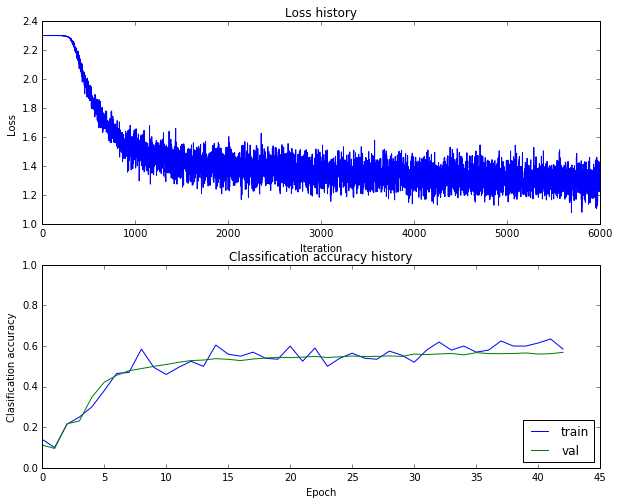

Validation accuracy:  0.5725


In [15]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None
print(X_train_feats.shape, X_val_feats.shape)

stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=6000, batch_size=200,
            learning_rate=0.05, learning_rate_decay=0.99,
            reg=.005, verbose=True)


show_chart(stats)

# Predict on the validation set
val_acc = (net.predict(X_val_feats) == y_val).mean()
print ('Validation accuracy: ', val_acc)
################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

In [ ]:

def dump_pickle(obj, filename):
    import pickle
    with open(filename + ".pickle", "wb") as output_file:
       pickle.dump(obj, output_file)
    
dump_pickle(X_train_feats, 'X_train_feats')
dump_pickle(mean_feat, 'mean_feat')
dump_pickle(std_feat, 'std_feat')

dump_pickle(X_val_feats, 'X_val_feats')

In [ ]:
X_test, y_test = load_CIFAR10_test()


X_test_feats = preprocess_data(X_test, mean_feat, std_feat)
X_test_feats.shape

cs231n/datasets/test_batch
Done extracting features for 1000 / 10000 images
Done extracting features for 2000 / 10000 images
Done extracting features for 3000 / 10000 images
Done extracting features for 4000 / 10000 images
Done extracting features for 5000 / 10000 images
Done extracting features for 6000 / 10000 images
Done extracting features for 7000 / 10000 images
Done extracting features for 8000 / 10000 images
Done extracting features for 9000 / 10000 images


In [ ]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print (test_acc)

# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!